---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Norah Jones
    affiliations:
      - id: cmu
        name: Carnegie Mellon University
        city: Pittsburgh
        state: PA
      - id: chicago
        name: University of Chicago
        city: Chicago
        state: IL
  - name: John Hamm
    affiliations:
      - ref: cmu
      - name: University of California, San Diego
        city: San Diego
        state: CA
number-sections: true
date: "2024-11-21"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LightcastData") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

df = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .option("multiLine", True) \
    .option("escape", "\"") \
    .csv("data/lightcast_job_postings.csv")

df.printSchema()

df.limit(5).toPandas()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/15 02:39:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: string (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = true)
 |-- MIN_EDULEVELS: integer (nul

25/04/15 02:39:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

,ID,LAST_UPDATED_DATE,LAST_UPDATED_TIMESTAMP,DUPLICATES,POSTED,EXPIRED,DURATION,SOURCE_TYPES,SOURCES,URL,...,NAICS_2022_2,NAICS_2022_2_NAME,NAICS_2022_3,NAICS_2022_3_NAME,NAICS_2022_4,NAICS_2022_4_NAME,NAICS_2022_5,NAICS_2022_5_NAME,NAICS_2022_6,NAICS_2022_6_NAME
0,1f57d95acf4dc67ed2819eb12f049f6a5c11782c,9/6/2024,2024-09-06 20:32:57.352 Z,0,6/2/2024,6/8/2024,6.0,"[\n ""Company""\n]","[\n ""brassring.com""\n]","[\n ""https://sjobs.brassring.com/TGnewUI/Sear...",...,44,Retail Trade,441,Motor Vehicle and Parts Dealers,4413,"Automotive Parts, Accessories, and Tire Retailers",44133,Automotive Parts and Accessories Retailers,441330,Automotive Parts and Accessories Retailers
1,0cb072af26757b6c4ea9464472a50a443af681ac,8/2/2024,2024-08-02 17:08:58.838 Z,0,6/2/2024,8/1/2024,NaN,"[\n ""Job Board""\n]","[\n ""maine.gov""\n]","[\n ""https://joblink.maine.gov/jobs/1085740""\n]",...,56,Administrative and Support and Waste Managemen...,561,Administrative and Support Services,5613,Employment Services,56132,Temporary Help Services,561320,Temporary Help Services
2,85318b12b3331fa490d32ad014379df01855c557,9/6/2024,2024-09-06 20:32:57.352 Z,1,6/2/2024,7/7/2024,35.0,"[\n ""Job Board""\n]","[\n ""dejobs.org""\n]","[\n ""https://dejobs.org/dallas-tx/data-analys...",...,52,Finance and Insurance,524,Insurance Carriers and Related Activities,5242,"Agencies, Brokerages, and Other Insurance Rela...",52429,Other Insurance Related Activities,524291,Claims Adjusting
3,1b5c3941e54a1889ef4f8ae55b401a550708a310,9/6/2024,2024-09-06 20:32:57.352 Z,1,6/2/2024,7/20/2024,48.0,"[\n ""Job Board""\n]","[\n ""disabledperson.com"",\n ""dejobs.org""\n]","[\n ""https://www.disabledperson.com/jobs/5948...",...,52,Finance and Insurance,522,Credit Intermediation and Related Activities,5221,Depository Credit Intermediation,52211,Commercial Banking,522110,Commercial Banking
4,cb5ca25f02bdf25c13edfede7931508bfd9e858f,6/19/2024,2024-06-19 07:00:00.000 Z,0,6/2/2024,6/17/2024,15.0,"[\n ""FreeJobBoard""\n]","[\n ""craigslist.org""\n]","[\n ""https://modesto.craigslist.org/sls/77475...",...,99,Unclassified Industry,999,Unclassified Industry,9999,Unclassified Industry,99999,Unclassified Industry,999999,Unclassified Industry


# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [6]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

df_model = df.select("SALARY", "MIN_YEARS_EXPERIENCE", "SALARY_FROM", "REMOTE_TYPE_NAME") \
             .dropna()

indexer = StringIndexer(inputCol="REMOTE_TYPE_NAME", outputCol="REMOTE_TYPE_INDEX")
df_indexed = indexer.fit(df_model).transform(df_model)

encoder = OneHotEncoder(inputCols=["REMOTE_TYPE_INDEX"], outputCols=["REMOTE_TYPE_VEC"])
df_encoded = encoder.fit(df_indexed).transform(df_indexed)

assembler = VectorAssembler(
    inputCols=["MIN_YEARS_EXPERIENCE", "SALARY_FROM", "REMOTE_TYPE_VEC"],
    outputCol="features"
)
df_features = assembler.transform(df_encoded).select("SALARY", "features")

df_features.show(5, truncate=False)

+------+--------------------------+
|SALARY|features                  |
+------+--------------------------+
|92962 |[2.0,79500.0,1.0,0.0,0.0] |
|107645|(5,[0,1],[10.0,91559.0])  |
|192800|[6.0,144600.0,1.0,0.0,0.0]|
|125900|[12.0,63200.0,1.0,0.0,0.0]|
|170000|[6.0,120000.0,1.0,0.0,0.0]|
+------+--------------------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [9]:
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)
print(f"train_data_columns: {train_data.count()}")
print(f"test_data_columns: {test_data.count()}")

train_data_columns: 18966


[Stage 16:>                                                         (0 + 1) / 1]

test_data_columns: 4731


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [11]:
import pandas as pd
import numpy as np

print("Length of coefficients:", len(lr_model.coefficients))
print("Length of StdErrors:", len(summary.coefficientStandardErrors))
print("Length of t-values:", len(summary.tValues))
print("Length of p-values:", len(summary.pValues))

min_len = min(
    len(lr_model.coefficients),
    len(summary.coefficientStandardErrors),
    len(summary.tValues),
    len(summary.pValues)
)

coef_df = pd.DataFrame({
    "Estimate": lr_model.coefficients.toArray()[:min_len],
    "StdError": summary.coefficientStandardErrors[:min_len],
    "tStat": summary.tValues[:min_len],
    "pValue": summary.pValues[:min_len]
})

coef_df["LowerCI"] = coef_df["Estimate"] - 1.96 * coef_df["StdError"]
coef_df["UpperCI"] = coef_df["Estimate"] + 1.96 * coef_df["StdError"]

coef_df

Length of coefficients: 5
Length of StdErrors: 6
Length of t-values: 6
Length of p-values: 6


,Estimate,StdError,tStat,pValue,LowerCI,UpperCI
0,2645.727994,40.585472,65.189041,0.000000,2566.180470,2725.275518
1,0.960871,0.003653,263.069606,0.000000,0.953712,0.968030
2,2078.797548,946.420144,2.196485,0.028069,223.814066,3933.781029
3,-3537.917440,973.600736,-3.633848,0.000280,-5446.174883,-1629.659998
4,3133.634121,1172.995236,2.671481,0.007558,834.563459,5432.704783


## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [14]:
import numpy as np

estimates = np.array(lr_model.coefficients.toArray()[:min_len])
std_errors = np.array(summary.coefficientStandardErrors[:min_len])
t_values = np.array(summary.tValues[:min_len])
p_values = np.array(summary.pValues[:min_len])

lower_ci = estimates - 1.96 * std_errors
upper_ci = estimates + 1.96 * std_errors
from pyspark.ml.feature import OneHotEncoderModel

input_features = ["MIN_YEARS_EXPERIENCE", "SALARY_FROM"]
encoded = encoder.fit(df_indexed)
num_ohe_cols = encoded.categorySizes[0]
ohe_feature_names = [f"REMOTE_TYPE_VEC_{i}" for i in range(num_ohe_cols)]
full_feature_names = input_features + ohe_feature_names

feature_names = full_feature_names[:min_len]

coef_summary = pd.DataFrame({
    "Feature": feature_names,
    "Estimate": estimates,
    "StdError": std_errors,
    "tStat": t_values,
    "pValue": p_values,
    "LowerCI": lower_ci,
    "UpperCI": upper_ci
})

coef_summary

,Feature,Estimate,StdError,tStat,pValue,LowerCI,UpperCI
0,MIN_YEARS_EXPERIENCE,2645.727994,40.585472,65.189041,0.000000,2566.180470,2725.275518
1,SALARY_FROM,0.960871,0.003653,263.069606,0.000000,0.953712,0.968030
2,REMOTE_TYPE_VEC_0,2078.797548,946.420144,2.196485,0.028069,223.814066,3933.781029
3,REMOTE_TYPE_VEC_1,-3537.917440,973.600736,-3.633848,0.000280,-5446.174883,-1629.659998
4,REMOTE_TYPE_VEC_2,3133.634121,1172.995236,2.671481,0.007558,834.563459,5432.704783


# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


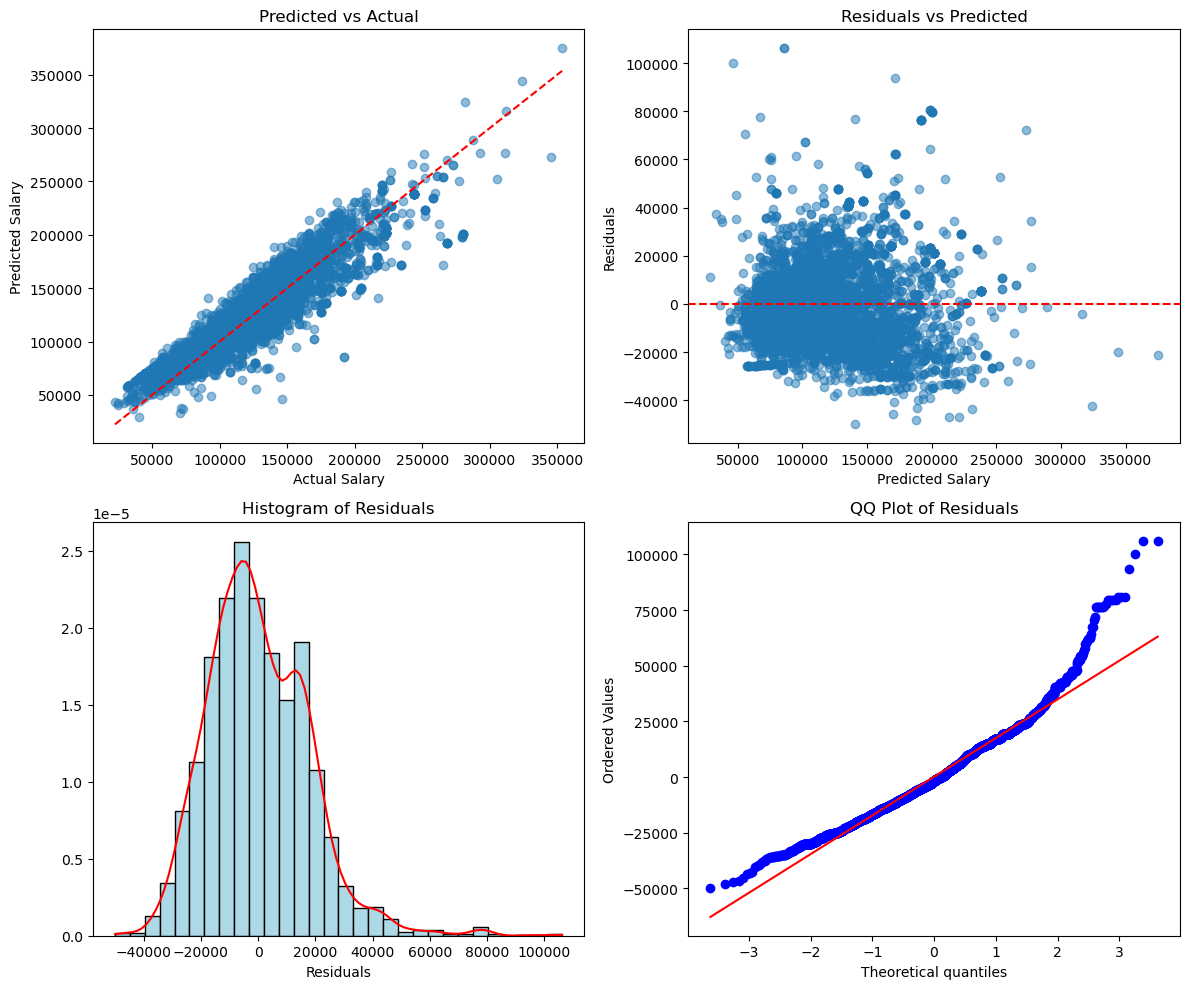

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Extract prediction and residuals
predictions = lr_model.transform(test_data)
predictions_pd = predictions.select("prediction", "SALARY").toPandas()
predictions_pd["residuals"] = predictions_pd["SALARY"] - predictions_pd["prediction"]

y_true = predictions_pd["SALARY"].values
y_pred = predictions_pd["prediction"].values
residuals = predictions_pd["residuals"].values

# Plot
plt.figure(figsize=(12, 10))

# 1. Predicted vs Actual
plt.subplot(2, 2, 1)
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.title("Predicted vs Actual")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")

# 2. Residuals vs Predicted
plt.subplot(2, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")

# 3. Histogram of Residuals
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=30, color='lightblue', edgecolor='black', density=True)
kde = stats.gaussian_kde(residuals)
x_vals = np.linspace(residuals.min(), residuals.max(), 100)
plt.plot(x_vals, kde(x_vals), color='red')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")

# 4. QQ Plot
plt.subplot(2, 2, 4)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")

plt.tight_layout()
plt.savefig("_output/diagnostic_plots_clean.png")
plt.show()


# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

R²: 0.8394
RMSE: 17667.41


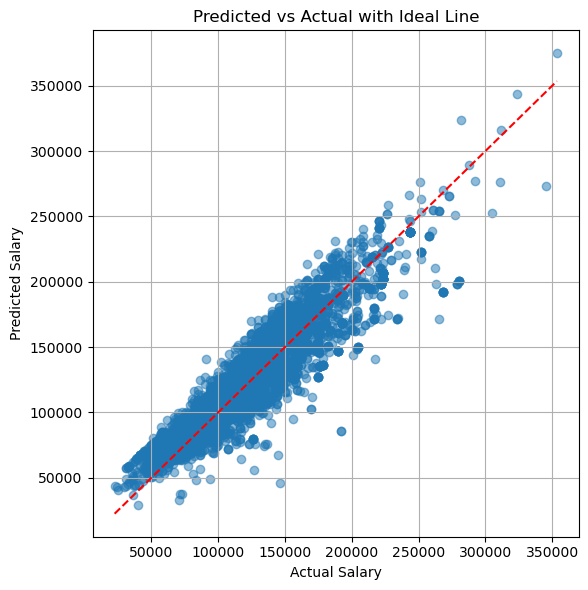

In [21]:
test_result = lr_model.evaluate(test_data)

print(f"R²: {test_result.r2:.4f}")
print(f"RMSE: {test_result.rootMeanSquaredError:.2f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Predicted vs Actual with Ideal Line")
plt.grid(True)
plt.tight_layout()
plt.savefig("_output/predicted_vs_actual.png")
plt.show()

## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

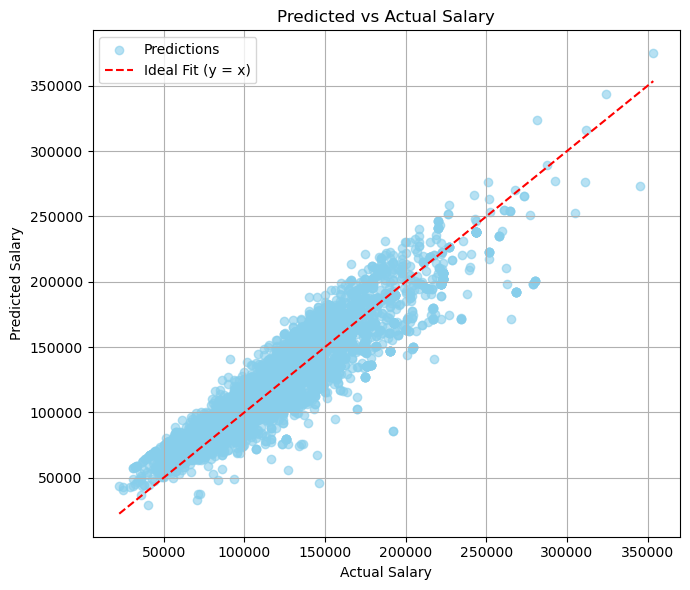

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
plt.scatter(y_true, y_pred, color='skyblue', alpha=0.6, label="Predictions")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label="Ideal Fit (y = x)")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Predicted vs Actual Salary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("_output/model_evaluation_plot.png")
plt.show()


# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
